# KOBE Bryant Shot Selection

Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

---
# Modeling: Neural Network
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Setting a Random Seed for Consistency

In [3]:
from numpy.random import seed
seed(1)

# Set random seed
tf.random.set_seed(42)

# Read In Data

In [6]:
df = pd.read_csv('../data/kobe_data_cleaned.csv', index_col = 'shot_id')
print(df.shape)
df.head()

(25697, 11)


,combined_shot_type,period,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,home_away,time_sec_remaining
shot_id,,,,,,,,,,,
2,Jump Shot,1,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-01 POR,0,622
3,Jump Shot,1,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-01 POR,0,465
4,Jump Shot,1,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-01 POR,0,412
5,Dunk,2,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-01 POR,0,379
6,Jump Shot,3,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-01 POR,0,572


# Modeling

First of all, it should be clear to everyone that Kobe Bryant is the Best Basketball Player to have ever lived. 
>Not to be confused with Michael Jordan, who is the GOAT. 

Secondly, Basketball is about 1 thing and 1 thing only, buckets. We are less interested in minimizing false positives or false negatives as we are not dealing with fraud detection or medical diagnosis, where these missclassification metrics are more important. 
> **Therefore, accuracy is the metric that is most important to us.** 
---
### There are 5 datasets I want to try when choosing our features:
1. **All remaining variables**
2. **Shot location and shot type variables w/ opponent**
3. **Shot location and shot type variables**
4. **Basic shot location variables**
5. **Only ```shot_distance```**

## Set our X's and Y for our model

In [7]:
y = df['shot_made_flag'].astype(int)

X1 = df.drop(columns=['shot_made_flag'])
X2 = df[['combined_shot_type', 'shot_distance', 'shot_zone_area', 'opponent']]
X3 = df[['combined_shot_type', 'shot_distance', 'shot_zone_area']]
X4 = df[['shot_distance', 'shot_zone_area', ]]
X5 = df[['shot_distance']]

## Dummified Categoricals

In [8]:
dum_X1 = pd.get_dummies(X1, columns=['combined_shot_type', 'period', 'shot_type', 
                                     'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 
                                     'opponent', 'home_away'], 
                        drop_first=True)
print(dum_X1.shape)
dum_X1.head()

(25697, 558)


,shot_distance,time_sec_remaining,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_2,period_3,period_4,...,opponent_2015-16 OKC,opponent_2015-16 PHI,opponent_2015-16 PHX,opponent_2015-16 POR,opponent_2015-16 SAC,opponent_2015-16 SAS,opponent_2015-16 TOR,opponent_2015-16 UTA,opponent_2015-16 WAS,home_away_1
shot_id,,,,,,,,,,,,,,,,,,,,,
2,15,622,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,465,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,412,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,379,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,14,572,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dum_X2 = pd.get_dummies(X2, columns=['combined_shot_type', 'shot_zone_area', 'opponent'], 
                        drop_first=True)
print(dum_X2.shape)
dum_X2.head()

(25697, 539)


,shot_distance,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),...,opponent_2015-16 NYK,opponent_2015-16 OKC,opponent_2015-16 PHI,opponent_2015-16 PHX,opponent_2015-16 POR,opponent_2015-16 SAC,opponent_2015-16 SAS,opponent_2015-16 TOR,opponent_2015-16 UTA,opponent_2015-16 WAS
shot_id,,,,,,,,,,,,,,,,,,,,,
2,15,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,16,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,14,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dum_X3 = pd.get_dummies(X3, columns=['combined_shot_type', 'shot_zone_area',], 
                        drop_first=True)
print(dum_X3.shape)
dum_X3.head()

(25697, 11)


,shot_distance,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R)
shot_id,,,,,,,,,,,
2,15,0,0,1,0,0,0,0,1,0,0
3,16,0,0,1,0,0,0,1,0,0,0
4,22,0,0,1,0,0,0,0,0,1,0
5,0,1,0,0,0,0,1,0,0,0,0
6,14,0,0,1,0,0,0,0,1,0,0


In [11]:
dum_X4 = pd.get_dummies(X4, columns=['shot_zone_area',], 
                        drop_first=True)
print(dum_X4.shape)
dum_X4.head()

(25697, 6)


,shot_distance,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R)
shot_id,,,,,,
2,15,0,0,1,0,0
3,16,0,1,0,0,0
4,22,0,0,0,1,0
5,0,1,0,0,0,0
6,14,0,0,1,0,0


**X5 has no categorical features so dummification is not needed on that dataset.**

## Train/Test Split and Scaling

In [58]:
# Train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(dum_X1, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X1_train_sc = sc.fit_transform(X1_train)
X1_test_sc = sc.transform(X1_test)

n1_input = X1_train_sc.shape[1]

In [59]:
# Train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(dum_X2, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X2_train_sc = sc.fit_transform(X2_train)
X2_test_sc = sc.transform(X2_test)

n2_input = X2_train_sc.shape[1]

In [60]:
# Train/test split
X3_train, X3_test, y3_train, y3_test = train_test_split(dum_X3, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X3_train_sc = sc.fit_transform(X3_train)
X3_test_sc = sc.transform(X3_test)

n3_input = X3_train_sc.shape[1]

In [61]:
# Train/test split
X4_train, X4_test, y4_train, y4_test = train_test_split(dum_X4, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X4_train_sc = sc.fit_transform(X4_train)
X4_test_sc = sc.transform(X4_test)

n4_input = X4_train_sc.shape[1]

In [62]:
# Train/test split
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, stratify=y, random_state=42)

# Scale data
sc = StandardScaler()
X5_train_sc = sc.fit_transform(X5_train)
X5_test_sc = sc.transform(X5_test)

n5_input = X5_train_sc.shape[1]

## Model 0: Null Model

In [24]:
y.value_counts(normalize=True)

0    0.553839
1    0.446161
Name: shot_made_flag, dtype: float64

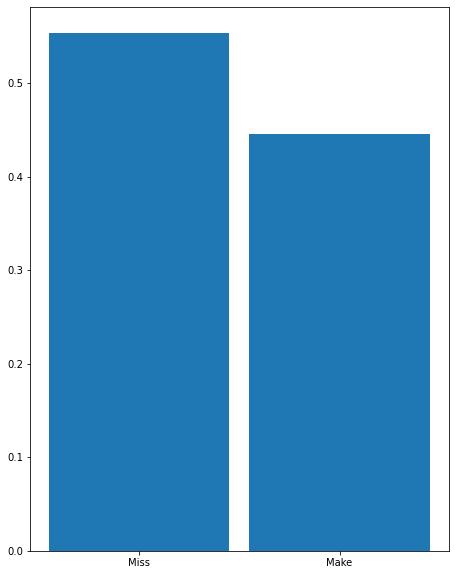

In [25]:
plt.figure(figsize=(7.5,10))
plt.bar(['Miss','Make'], 
        y.value_counts(normalize=True).values,
        width = 0.9);

>**Our null model has an accuracy of 55% when predicting 'Miss', the majority class, for all instances.**

## Model 1: Dense NN

### Dataset 1

In [85]:
model = Sequential()

# Layer 1: Input
#model.add(BatchNormalization())
model.add(Dense(n1_input, # how many neurons/nodes in the layer
                input_shape=(n1_input,), # how many features you have
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)
               ))
model.add(Dropout(0.05))

# Layer 2: Hidden 1
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.1))

# Layer 3: Hidden 2
model.add(Dense(128, activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)))
model.add(Dropout(0.15))
           
# Layer 4: Hidden 3
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.2))

# Layer 5: Output
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='bce', 
              optimizer='adam', 
              metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2)


history = model.fit(
    X1_train_sc,
    y1_train,
    validation_data=(X1_test_sc, y1_test),
    epochs=200,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/200
603/603 - 4s - loss: 0.9594 - accuracy: 0.5938 - val_loss: 0.7986 - val_accuracy: 0.6006
Epoch 2/200
603/603 - 3s - loss: 0.7389 - accuracy: 0.6067 - val_loss: 0.7062 - val_accuracy: 0.6000
Epoch 3/200
603/603 - 3s - loss: 0.6889 - accuracy: 0.6103 - val_loss: 0.6839 - val_accuracy: 0.5988
Epoch 4/200
603/603 - 3s - loss: 0.6736 - accuracy: 0.6124 - val_loss: 0.6819 - val_accuracy: 0.6016
Epoch 5/200
603/603 - 3s - loss: 0.6702 - accuracy: 0.6135 - val_loss: 0.6793 - val_accuracy: 0.5989
Epoch 6/200
603/603 - 3s - loss: 0.6667 - accuracy: 0.6175 - val_loss: 0.6817 - val_accuracy: 0.6006
Epoch 7/200
603/603 - 3s - loss: 0.6619 - accuracy: 0.6192 - val_loss: 0.6809 - val_accuracy: 0.5981
Epoch 8/200
603/603 - 3s - loss: 0.6585 - accuracy: 0.6190 - val_loss: 0.6785 - val_accuracy: 0.6008
Epoch 9/200
603/603 - 3s - loss: 0.6560 - accuracy: 0.6205 - val_loss: 0.6787 - val_accuracy: 0.5992
Epoch 00009: early stopping


**Analysis**
- Accuracy started out around 60% and stablized, much better than our null model of 55%.
- Train and Test accuracy are close. If anything, there is very slight overfitting.
- L2 Regularization helped stablize and improve accuracy.
- BatchNormalization actually slightly reduced accuracy.
- Dropout layers stablized the increase and top at 60%.

**Although we are mainly concerned with accuracy, we may be able to gather some insight through misclassification statistics.**

In [86]:
preds = np.round(model.predict(X1_test_sc),0)

# Recall/Sensitivity
print('Recall = ', metrics.recall_score(y1_test, preds))

# Precision
print('Precision = ', metrics.precision_score(y1_test, preds))

cm = metrics.confusion_matrix(y1_test, preds)
tn, fp, fn, tp = cm.ravel()

# Specificity
print("Specificity = ", tn / (tn+fp))

Recall =  0.2661318451342867
Precision =  0.6183144246353323
Specificity =  0.8676222596964587


In [87]:
m1_d1 = [60, 59.92, 
         round(metrics.recall_score(y1_test, preds)*100,2), 
         round(metrics.precision_score(y1_test, preds)*100,2),
         round((tn / (tn+fp))*100,2)
        ]

### Dataset 2

In [88]:
model = Sequential()

# Layer 1: Input
#model.add(BatchNormalization())
model.add(Dense(n2_input, # how many neurons/nodes in the layer
                input_shape=(n2_input,), # how many features you have
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)
               ))
model.add(Dropout(0.05))

# Layer 2: Hidden 1
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.1))

# Layer 3: Hidden 2
model.add(Dense(128, activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)))
model.add(Dropout(0.15))
           
# Layer 4: Hidden 3
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.2))

# Layer 5: Output
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='bce', 
              optimizer='adam', 
              metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2)


history = model.fit(
    X2_train_sc,
    y2_train,
    validation_data=(X2_test_sc, y2_test),
    epochs=200,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/200
603/603 - 4s - loss: 0.9339 - accuracy: 0.5919 - val_loss: 0.7814 - val_accuracy: 0.5997
Epoch 2/200
603/603 - 3s - loss: 0.7300 - accuracy: 0.6039 - val_loss: 0.7019 - val_accuracy: 0.5969
Epoch 3/200
603/603 - 3s - loss: 0.6866 - accuracy: 0.6106 - val_loss: 0.6838 - val_accuracy: 0.5983
Epoch 4/200
603/603 - 3s - loss: 0.6748 - accuracy: 0.6136 - val_loss: 0.6807 - val_accuracy: 0.5995
Epoch 5/200
603/603 - 3s - loss: 0.6707 - accuracy: 0.6143 - val_loss: 0.6800 - val_accuracy: 0.5980
Epoch 6/200
603/603 - 3s - loss: 0.6649 - accuracy: 0.6199 - val_loss: 0.6805 - val_accuracy: 0.5998
Epoch 7/200
603/603 - 3s - loss: 0.6618 - accuracy: 0.6201 - val_loss: 0.6813 - val_accuracy: 0.5969
Epoch 8/200
603/603 - 3s - loss: 0.6575 - accuracy: 0.6245 - val_loss: 0.6826 - val_accuracy: 0.5974
Epoch 9/200
603/603 - 3s - loss: 0.6542 - accuracy: 0.6256 - val_loss: 0.6756 - val_accuracy: 0.6016
Epoch 10/200
603/603 - 3s - loss: 0.6523 - accuracy: 0.6266 - val_loss: 0.6856 - val_accura

**Analysis**
- Accuracy started out around 60% and stablized around 59.5%, about on par with our first dataset model.
- Train and Test accuracy are very close. If anything, there is very slight overfitting.
- L2 Regularization did little to improve accuracy.
- BatchNormalization again reduced accuracy.
- Dropout layers increased accuracy by a negligible amount.

**Although we are mainly concerned with accuracy, we may be able to gather some insight through misclassification statistics.**

In [89]:
preds = np.round(model.predict(X2_test_sc),0)

# Recall/Sensitivity
print('Recall = ', metrics.recall_score(y2_test, preds))

# Precision
print('Precision = ', metrics.precision_score(y2_test, preds))

cm = metrics.confusion_matrix(y2_test, preds)
tn, fp, fn, tp = cm.ravel()

# Specificity
print("Specificity = ", tn / (tn+fp))

Recall =  0.25636553889082664
Precision =  0.607940446650124
Specificity =  0.866779089376054


In [90]:
m1_d2 = [59.5, 59.44, 
          round(metrics.recall_score(y2_test, preds)*100,2), 
          round(metrics.precision_score(y2_test, preds)*100,2),
          round((tn / (tn+fp))*100,2)
         ]

### Dataset 3

In [91]:
model = Sequential()

# Layer 1: Input
#model.add(BatchNormalization())
model.add(Dense(n3_input, # how many neurons/nodes in the layer
                input_shape=(n3_input,), # how many features you have
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)
               ))
model.add(Dropout(0.05))

# Layer 2: Hidden 1
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.1))

# Layer 3: Hidden 2
model.add(Dense(128, activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)))
model.add(Dropout(0.15))
           
# Layer 4: Hidden 3
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.2))

# Layer 5: Output
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='bce', 
              optimizer='adam', 
              metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2)


history = model.fit(
    X3_train_sc,
    y3_train,
    validation_data=(X3_test_sc, y3_test),
    epochs=200,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/200
603/603 - 2s - loss: 0.7452 - accuracy: 0.6101 - val_loss: 0.6972 - val_accuracy: 0.6123
Epoch 2/200
603/603 - 1s - loss: 0.6832 - accuracy: 0.6134 - val_loss: 0.6720 - val_accuracy: 0.6128
Epoch 3/200
603/603 - 1s - loss: 0.6681 - accuracy: 0.6118 - val_loss: 0.6644 - val_accuracy: 0.6123
Epoch 4/200
603/603 - 1s - loss: 0.6635 - accuracy: 0.6129 - val_loss: 0.6613 - val_accuracy: 0.6128
Epoch 5/200
603/603 - 1s - loss: 0.6621 - accuracy: 0.6128 - val_loss: 0.6597 - val_accuracy: 0.6123
Epoch 6/200
603/603 - 1s - loss: 0.6598 - accuracy: 0.6150 - val_loss: 0.6607 - val_accuracy: 0.6128
Epoch 7/200
603/603 - 1s - loss: 0.6592 - accuracy: 0.6149 - val_loss: 0.6598 - val_accuracy: 0.6129
Epoch 8/200
603/603 - 1s - loss: 0.6591 - accuracy: 0.6150 - val_loss: 0.6587 - val_accuracy: 0.6123
Epoch 9/200
603/603 - 1s - loss: 0.6583 - accuracy: 0.6153 - val_loss: 0.6594 - val_accuracy: 0.6103
Epoch 10/200
603/603 - 1s - loss: 0.6590 - accuracy: 0.6135 - val_loss: 0.6589 - val_accura

**Analysis**
- Accuracy started out and stablized around 61%.
- Train and Test accuracy are almost identical. There is no evidence of overfitting.
- L2 Regularization did little to improve accuracy.
- BatchNormalization again reduced accuracy.
- Dropout layers slightly reduced accuracy.

**Although we are mainly concerned with accuracy, we may be able to gather some insight through misclassification statistics.**

In [92]:
preds = np.round(model.predict(X3_test_sc),0)

# Recall/Sensitivity
print('Recall = ', metrics.recall_score(y3_test, preds))

# Precision
print('Precision = ', metrics.precision_score(y3_test, preds))

cm = metrics.confusion_matrix(y3_test, preds)
tn, fp, fn, tp = cm.ravel()

# Specificity
print("Specificity = ", tn / (tn+fp))

Recall =  0.32403208929194277
Precision =  0.6281271129141311
Specificity =  0.8454187745924677


In [93]:
m1_d3 = [61, 61.28, 
          round(metrics.recall_score(y3_test, preds)*100,2), 
          round(metrics.precision_score(y3_test, preds)*100,2),
          round((tn / (tn+fp))*100,2)
         ]

### Dataset 4

In [94]:
model = Sequential()

# Layer 1: Input
#model.add(BatchNormalization())
model.add(Dense(n4_input, # how many neurons/nodes in the layer
                input_shape=(n4_input,), # how many features you have
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)
               ))
model.add(Dropout(0.05))

# Layer 2: Hidden 1
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.1))

# Layer 3: Hidden 2
model.add(Dense(128, activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)))
model.add(Dropout(0.15))
           
# Layer 4: Hidden 3
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.2))

# Layer 5: Output
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='bce', 
              optimizer='adam', 
              metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2)


history = model.fit(
    X4_train_sc,
    y4_train,
    validation_data=(X4_test_sc, y4_test),
    epochs=200,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/200
603/603 - 2s - loss: 0.7322 - accuracy: 0.5962 - val_loss: 0.6909 - val_accuracy: 0.6047
Epoch 2/200
603/603 - 1s - loss: 0.6840 - accuracy: 0.6012 - val_loss: 0.6765 - val_accuracy: 0.6056
Epoch 3/200
603/603 - 1s - loss: 0.6760 - accuracy: 0.6034 - val_loss: 0.6738 - val_accuracy: 0.6050
Epoch 4/200
603/603 - 1s - loss: 0.6748 - accuracy: 0.6045 - val_loss: 0.6728 - val_accuracy: 0.6050
Epoch 5/200
603/603 - 1s - loss: 0.6744 - accuracy: 0.6051 - val_loss: 0.6717 - val_accuracy: 0.6065
Epoch 6/200
603/603 - 1s - loss: 0.6731 - accuracy: 0.6052 - val_loss: 0.6725 - val_accuracy: 0.6065
Epoch 7/200
603/603 - 1s - loss: 0.6723 - accuracy: 0.6061 - val_loss: 0.6726 - val_accuracy: 0.6065
Epoch 8/200
603/603 - 1s - loss: 0.6730 - accuracy: 0.6068 - val_loss: 0.6718 - val_accuracy: 0.6050
Epoch 9/200
603/603 - 1s - loss: 0.6726 - accuracy: 0.6022 - val_loss: 0.6719 - val_accuracy: 0.6050
Epoch 10/200
603/603 - 1s - loss: 0.6721 - accuracy: 0.6054 - val_loss: 0.6717 - val_accura

**Analysis**
- Accuracy started out and stablized around 60.5%.
- Train and Test accuracy are almost identical. There is no evidence of overfitting.
- L2 Regularization did little to improve accuracy.
- BatchNormalization again reduced accuracy.
- Dropout layers increased accuracy by a negligible amount.

**Although we are mainly concerned with accuracy, we may be able to gather some insight through misclassification statistics.**

In [95]:
preds = np.round(model.predict(X4_test_sc),0)

# Recall/Sensitivity
print('Recall = ', metrics.recall_score(y4_test, preds))

# Precision
print('Precision = ', metrics.precision_score(y4_test, preds))

cm = metrics.confusion_matrix(y4_test, preds)
tn, fp, fn, tp = cm.ravel()

# Specificity
print("Specificity = ", tn / (tn+fp))

Recall =  0.3344959888385072
Precision =  0.6073464217859404
Specificity =  0.8257448004496908


In [97]:
m1_d4 = [60.5, 60.65, 
          round(metrics.recall_score(y4_test, preds)*100,2), 
          round(metrics.precision_score(y4_test, preds)*100,2),
          round((tn / (tn+fp))*100,2)
         ]

### Dataset 5

In [98]:
model = Sequential()

# Layer 1: Input
#model.add(BatchNormalization())
model.add(Dense(n5_input, # how many neurons/nodes in the layer
                input_shape=(n5_input,), # how many features you have
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)
               ))
model.add(Dropout(0.05))

# Layer 2: Hidden 1
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.1))

# Layer 3: Hidden 2
model.add(Dense(128, activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001)))
model.add(Dropout(0.15))
           
# Layer 4: Hidden 3
model.add(Dense(64, # how many neurons/nodes in the layer
                activation='relu', # relu for hidden layer
                kernel_regularizer=l2(.001) # relu for hidden layer
               ))
model.add(Dropout(0.2))

# Layer 5: Output
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='bce', 
              optimizer='adam', 
              metrics=['accuracy'])



early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2)


history = model.fit(
    X5_train_sc,
    y5_train,
    validation_data=(X5_test_sc, y5_test),
    epochs=200,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/200
603/603 - 2s - loss: 0.7010 - accuracy: 0.5590 - val_loss: 0.6799 - val_accuracy: 0.5932
Epoch 2/200
603/603 - 1s - loss: 0.6793 - accuracy: 0.5693 - val_loss: 0.6774 - val_accuracy: 0.5932
Epoch 3/200
603/603 - 1s - loss: 0.6782 - accuracy: 0.5762 - val_loss: 0.6757 - val_accuracy: 0.5970
Epoch 4/200
603/603 - 1s - loss: 0.6775 - accuracy: 0.5821 - val_loss: 0.6746 - val_accuracy: 0.5998
Epoch 5/200
603/603 - 1s - loss: 0.6774 - accuracy: 0.5835 - val_loss: 0.6740 - val_accuracy: 0.5998
Epoch 6/200
603/603 - 1s - loss: 0.6766 - accuracy: 0.5811 - val_loss: 0.6739 - val_accuracy: 0.5970
Epoch 7/200
603/603 - 1s - loss: 0.6761 - accuracy: 0.5897 - val_loss: 0.6729 - val_accuracy: 0.6047
Epoch 8/200
603/603 - 1s - loss: 0.6750 - accuracy: 0.5956 - val_loss: 0.6707 - val_accuracy: 0.6065
Epoch 9/200
603/603 - 1s - loss: 0.6737 - accuracy: 0.5975 - val_loss: 0.6710 - val_accuracy: 0.6065
Epoch 10/200
603/603 - 1s - loss: 0.6745 - accuracy: 0.5978 - val_loss: 0.6710 - val_accura

**Analysis**
- Accuracy started out around 59.5% then improved and stablized to around 60.5%.
- Train and Test accuracy are almost identical. There is no evidence of overfitting.
- BatchNormalization again reduced accuracy.
- Dropout layers increased accuracy by a negligible amount.

**Although we are mainly concerned with accuracy, we may be able to gather some insight through misclassification statistics.**

In [99]:
preds = np.round(model.predict(X5_test_sc),0)

# Recall/Sensitivity
print('Recall = ', metrics.recall_score(y5_test, preds))

# Precision
print('Precision = ', metrics.precision_score(y5_test, preds))

cm = metrics.confusion_matrix(y5_test, preds)
tn, fp, fn, tp = cm.ravel()

# Specificity
print("Specificity = ", tn / (tn+fp))

Recall =  0.3344959888385072
Precision =  0.6073464217859404
Specificity =  0.8257448004496908


In [100]:
m1_d5 = [60.5, 60.65, 
          round(metrics.recall_score(y5_test, preds)*100,2), 
          round(metrics.precision_score(y5_test, preds)*100,2),
          round((tn / (tn+fp))*100,2)
         ]

## Model 1 Summary:

In [103]:
m1_df = pd.DataFrame([m1_d1, m1_d2, m1_d3, m1_d4, m1_d5], 
                     columns=['Avg Acc', 'Final Acc', 'Recall', 'Precision', 'Specificity'], 
                     index=['NN - Dataset 1', 'NN - Dataset 2', 'NN - Dataset 3', 'NN - Dataset 4', 'NN - Dataset 5']
                    )
m1_df

,Avg Acc,Final Acc,Recall,Precision,Specificity
NN - Dataset 1,60.0,59.92,26.61,61.83,86.76
NN - Dataset 2,59.5,59.44,25.64,60.79,86.68
NN - Dataset 3,61.0,61.28,32.40,62.81,84.54
NN - Dataset 4,60.5,60.65,33.45,60.73,82.57
NN - Dataset 5,60.5,60.65,33.45,60.73,82.57


**Analysis:** 
> From Model 1, our best model consisted of using Dataset 3. It had the highest average and final accuracy out of our models and also executed quickly.

*Note: I could have written a function to run them all one after another and it would have looked cleaner. However, I wanted to modify and try tuning hyperparameters individually, so I chose this approach.*

In [104]:
m1_df.to_csv('../data/m1_summary.csv')